In [6]:
import numpy as np

In [5]:
import botorch

In [4]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

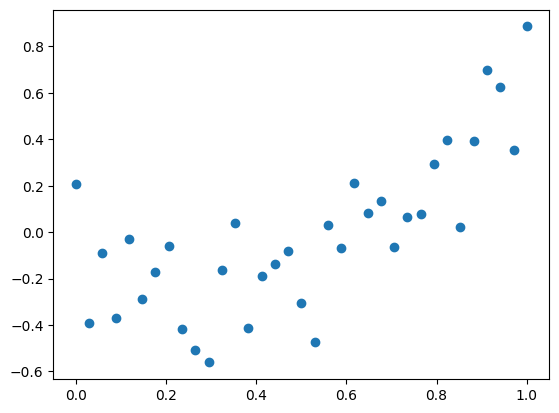

In [89]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 35)
# True function is sin(2*pi*x) with Gaussian noise
#train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.09)
# True function is x^3-1/4
train_y = train_x**3 - 0.25 + torch.randn(train_x.size()) * math.sqrt(0.04)
plt.scatter(train_x, train_y)

In [69]:
# megha's custom kernel (altered from example in gpytorch documentation)
from gpytorch.constraints import Positive
class meghaKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        #Q:  does this also add noise? or should we be adding a identity matrix * epsilon to the output to account for noise?
        diff.where(diff == 0, torch.as_tensor(1e-10)) 
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

In [97]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Same as above, but using Megha's kernel instead of the default RBF Kernel
class ExactGPModel2(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel2, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = meghaKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel2(train_x, train_y, likelihood)

In [99]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.lengthscale.item(),
        #model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.863   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.831   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.799   lengthscale: 0.779   noise: 0.598
Iter 4/50 - Loss: 0.767   lengthscale: 0.777   noise: 0.554
Iter 5/50 - Loss: 0.734   lengthscale: 0.754   noise: 0.513
Iter 6/50 - Loss: 0.701   lengthscale: 0.721   noise: 0.474
Iter 7/50 - Loss: 0.667   lengthscale: 0.684   noise: 0.437
Iter 8/50 - Loss: 0.634   lengthscale: 0.644   noise: 0.403
Iter 9/50 - Loss: 0.599   lengthscale: 0.604   noise: 0.371
Iter 10/50 - Loss: 0.565   lengthscale: 0.563   noise: 0.341
Iter 11/50 - Loss: 0.530   lengthscale: 0.524   noise: 0.313
Iter 12/50 - Loss: 0.494   lengthscale: 0.486   noise: 0.286
Iter 13/50 - Loss: 0.458   lengthscale: 0.450   noise: 0.262
Iter 14/50 - Loss: 0.422   lengthscale: 0.415   noise: 0.240
Iter 15/50 - Loss: 0.386   lengthscale: 0.381   noise: 0.219
Iter 16/50 - Loss: 0.352   lengthscale: 0.351   noise: 0.200
Iter 17/50 - Loss: 0.318   length

In [93]:
test_x = torch.linspace(0, 1, 1024)

posterior = model.forward(test_x)

#plt.scatter(train_x, train_y)

In [100]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 1024)
    posterior = likelihood(model(test_x))

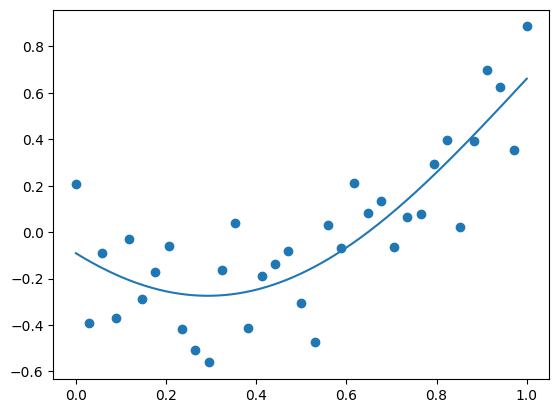

In [101]:

plt.scatter(train_x, train_y)

plt.plot(test_x, posterior.mean.detach())

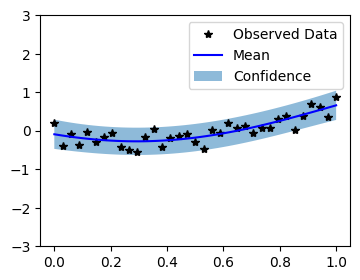

In [102]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

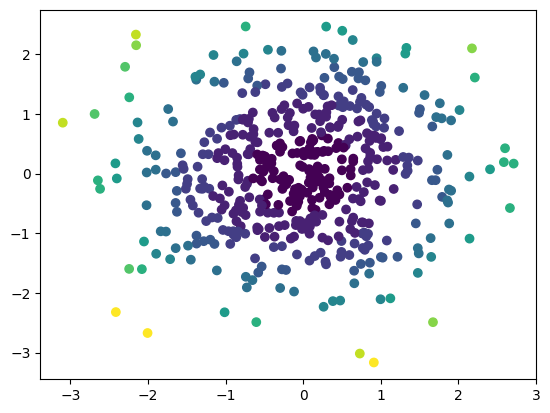

In [553]:
#START OF CLASSIFICATION GP REGRESSION
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    #data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
    data_fn = lambda x, y: x*x+y*y
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn
train_x, train_y, genfn = gen_data(500)
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

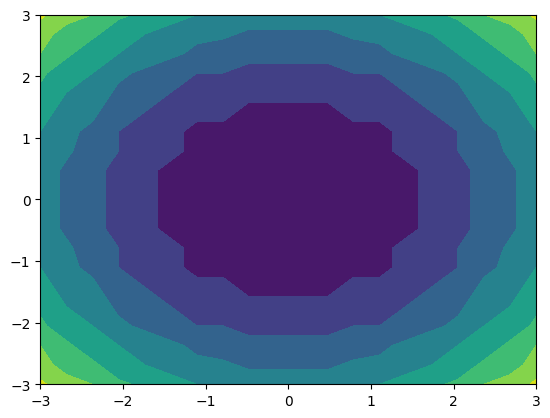

In [554]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [555]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

'torch.LongTensor'

In [556]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 29.759   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 26.819   lengthscale: 0.881   noise: 0.680
Iter 11/50 - Loss: 25.624   lengthscale: 1.071   noise: 0.710
Iter 16/50 - Loss: 25.003   lengthscale: 1.204   noise: 0.760
Iter 21/50 - Loss: 24.642   lengthscale: 1.290   noise: 0.801
Iter 26/50 - Loss: 24.394   lengthscale: 1.334   noise: 0.832
Iter 31/50 - Loss: 24.213   lengthscale: 1.354   noise: 0.856
Iter 36/50 - Loss: 24.073   lengthscale: 1.361   noise: 0.861
Iter 41/50 - Loss: 23.958   lengthscale: 1.360   noise: 0.838
Iter 46/50 - Loss: 23.863   lengthscale: 1.351   noise: 0.800


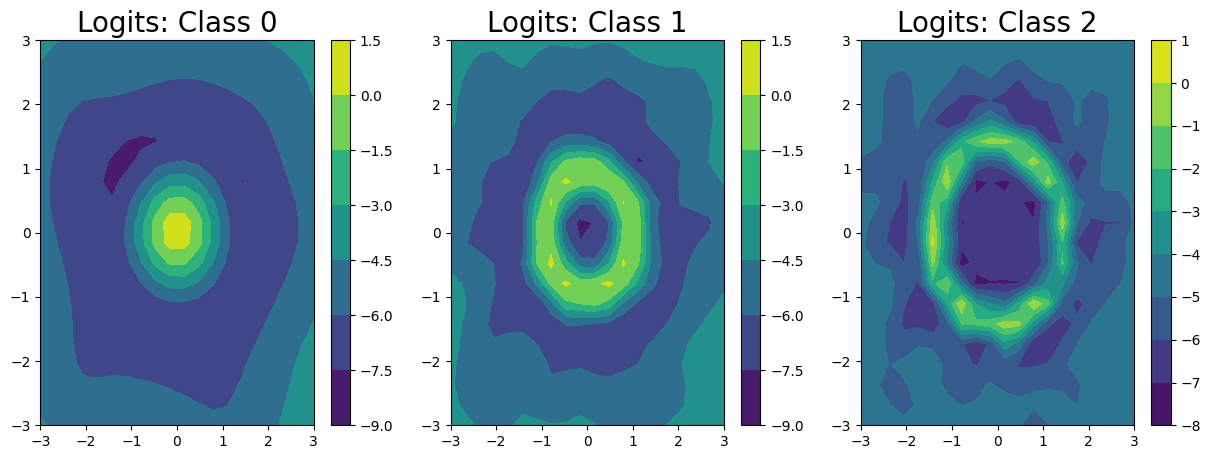

In [557]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Text(0.5, 1.0, 'Estimated Response')

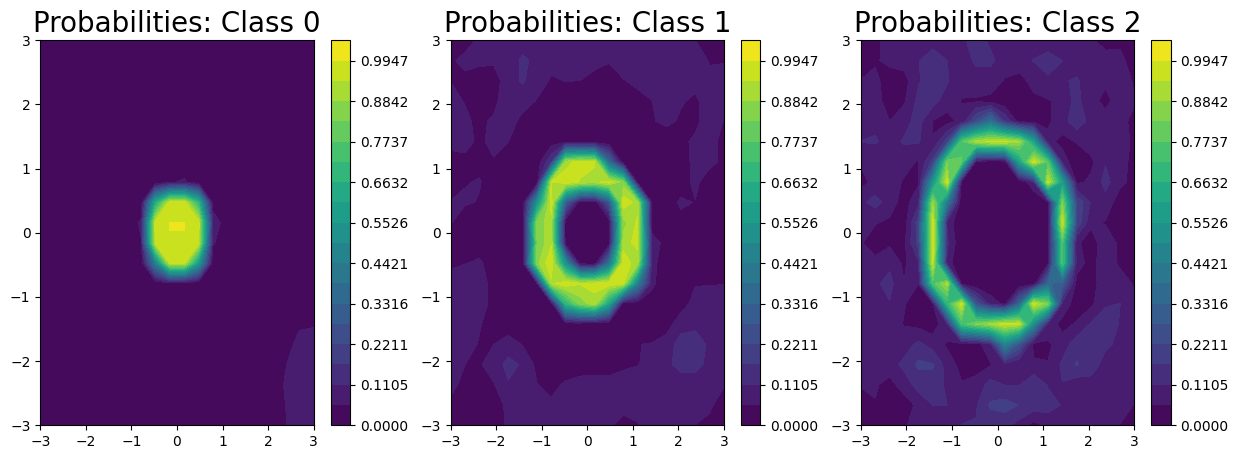

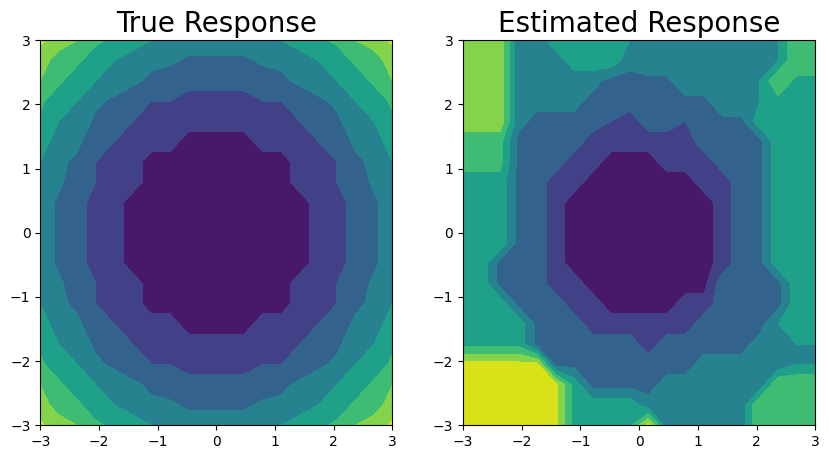

In [558]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)

In [561]:
probabilities

tensor([[0.0232, 0.0195, 0.0184,  ..., 0.0404, 0.0428, 0.0463],
        [0.0468, 0.0532, 0.0368,  ..., 0.0554, 0.0427, 0.0436],
        [0.0390, 0.0387, 0.0513,  ..., 0.0475, 0.0496, 0.0410],
        ...,
        [0.0105, 0.0094, 0.0094,  ..., 0.2317, 0.2971, 0.3385],
        [0.0088, 0.0087, 0.0100,  ..., 0.0124, 0.0143, 0.0163],
        [0.6068, 0.6090, 0.5965,  ..., 0.0085, 0.0100, 0.0120]])

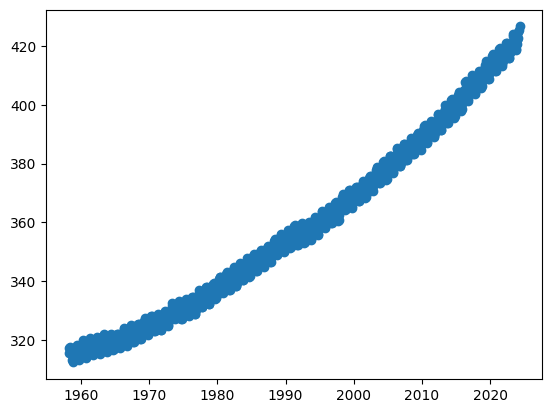

In [707]:
#FITTING A GP TO WEATHER TEST DATA
import pandas as pd
df = pd.read_csv('mauna_kea_co2.csv')
train_x= gpytorch.Tensor(df["decimal date"]).double()
train_y = gpytorch.Tensor(df["average"]).double()
x_min = train_x.min()
x_max = train_x.max()
x_range = x_max-x_min
y_mean = train_y.mean()
y_std = train_y.std()


import scipy as sp

#train_y = torch.tensor(sp.signal.detrend(train_y))

#train_y = train_x.sin()

# train_x -= train_x.min()
# train_x /= train_x.max()

# train_y = train_y- train_y.mean()
# train_y/= train_y.std()


def denormalize_x ( i ): 
    return i*(x_range)+x_min
def denormalize_y ( i ): 
    return i*y_std+y_mean
    
plt.scatter(train_x, train_y)

In [708]:
y_std

tensor(31.6195, dtype=torch.float64)

In [709]:
x1 = torch.tensor([0])
x2 = torch.linspace(0, 1, 256)

c = model.covar_module.kernels[1].base_kernel(x1=x1, x2=x2)[:]

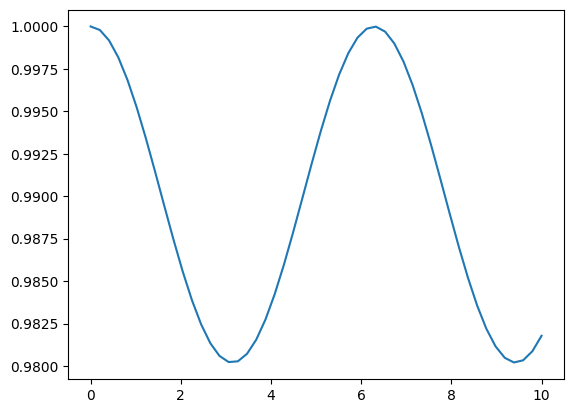

In [710]:
r = np.linspace(0, 10)


p = 2
l = 100

c = np.exp(-2 * np.sin(r/p)**2 / l)

plt.plot(r, c)

In [744]:

seasonal_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_constraint = gpytorch.constraints.Interval(1, 100))
                                               *gpytorch.kernels.PeriodicKernel(lengthscale_constraint = gpytorch.constraints.Interval(0.02, 0.25),
                                                           
                                                                                                                           period_length_prior 
                                                                                 = gpytorch.priors.NormalPrior(1, 0.001 , 
                                                                                                               validate_args=False, 
                                                                                                               transform=None)), outputscale_constraint=gpytorch.constraints.GreaterThan(1))
long_term_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_constraint = gpytorch.constraints.GreaterThan(0.5)), outputscale_constraint=gpytorch.constraints.GreaterThan(1))
irregularity_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(constant=350)
        #Should I be using a linear kernel instead?

        self.covar_module = (seasonal_kernel + long_term_kernel +irregularity_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0, 0.01))
model = ExactGPModel(train_x, train_y, likelihood)


model.mean_module.constant = train_y.mean()

model.covar_module.kernels[1].base_kernel.lengthscale = 50
model.covar_module.kernels[1].outputscale = 15

model.covar_module.kernels[0].outputscale = 5
model.covar_module.kernels[0].base_kernel.kernels[0].lengthscale = 5
# # model.covar_module.kernels[0].base_kernel.kernels[1].lengthscale.item(),
# model.covar_module.kernels[1].base_kernel.lengthscale.item(),
# model.covar_module.kernels[0].outputscale.item(),
# model.covar_module.kernels[1].outputscale.item(),
# model.covar_module.kernels[0].base_kernel.kernels[1].period_length.item(),
# init_period_length = 1/x_range
# model.covar_module.kernels[1].base_kernel.period_length = init_period_length

In [712]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    if (i + 1) % 10 == 0:
    
        print('Iter %d/%d - Loss: %.3f  mean %.3f lengthscale 1: %.3f lengthscale 2:%.3f lengthscale 3: %.3f scale factor %.3f  scale factor %.3f  period length: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            #model.covar_module.lengthscale.item(),
            model.mean_module.constant,
            model.covar_module.kernels[0].base_kernel.kernels[0].lengthscale.item(),
            model.covar_module.kernels[0].base_kernel.kernels[1].lengthscale.item(),
            model.covar_module.kernels[1].base_kernel.lengthscale.item(),
            model.covar_module.kernels[0].outputscale.item(),
            model.covar_module.kernels[1].outputscale.item(),
            model.covar_module.kernels[0].base_kernel.kernels[1].period_length.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 10/200 - Loss: 12.530  mean 359.928 lengthscale 1: 3.020 lengthscale 2:0.111 lengthscale 3: 49.101 scale factor 5.605  scale factor 15.896  period length: 1.129  noise: 0.006
Iter 20/200 - Loss: 2.265  mean 360.895 lengthscale 1: 2.449 lengthscale 2:0.110 lengthscale 3: 48.110 scale factor 5.842  scale factor 16.874  period length: 0.971  noise: 0.007
Iter 30/200 - Loss: 2.314  mean 361.812 lengthscale 1: 2.488 lengthscale 2:0.116 lengthscale 3: 47.135 scale factor 5.750  scale factor 17.815  period length: 0.969  noise: 0.007
Iter 40/200 - Loss: 2.081  mean 362.663 lengthscale 1: 2.848 lengthscale 2:0.126 lengthscale 3: 46.188 scale factor 5.478  scale factor 18.708  period length: 1.029  noise: 0.007
Iter 50/200 - Loss: 1.577  mean 363.438 lengthscale 1: 3.522 lengthscale 2:0.137 lengthscale 3: 45.272 scale factor 5.123  scale factor 19.551  period length: 0.982  noise: 0.007
Iter 60/200 - Loss: 1.275  mean 364.135 lengthscale 1: 4.485 lengthscale 2:0.147 lengthscale 3: 44.389 s

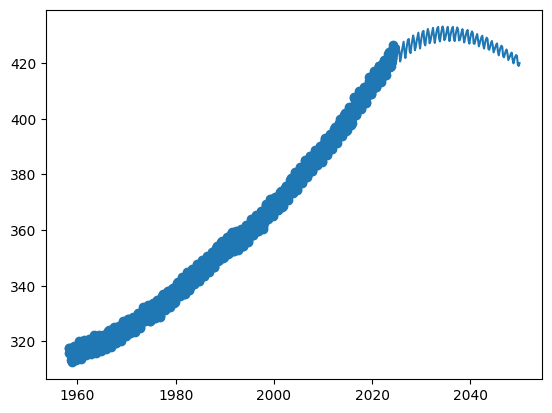

In [714]:
test_x = torch.linspace(2020, 2050, 512)

posterior = model.forward(test_x)

model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(1960, 2050, 512)
    posterior = likelihood(model(test_x))

plt.scatter(train_x, train_y)
plt.plot(test_x, posterior.mean.detach())

In [853]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 2050, 1024)
    observed_pred = likelihood(model(test_x))
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([300, 500])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 2 but got size 1 for tensor number 1 in the list.

In [758]:
x = train_x
y = train_y


mask = (x < 1970) | (x > 2000)

x = x[mask].unsqueeze(1)
y = y[mask].unsqueeze(1)

In [759]:
x.shape, y.shape

(torch.Size([434, 1]), torch.Size([434, 1]))

In [801]:
#gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_constraint = gpytorch.constraints.GreaterThan(0.5)), outputscale_constraint=gpytorch.constraints.GreaterThan(1))

from gpytorch.constraints import Positive
class custom_scaled_matern_kernel(gpytorch.kernels.Kernel):
    has_lengthscale = True
    
    def __init__(self, scale_prior = None, scale_constraint = None,  **kwargs):
        super().__init__(**kwargs)

        outputscale = torch.zeros(*self.batch_shape) if len(self.batch_shape) else torch.tensor(0.0)
        self.register_parameter(name="raw_outputscale", parameter=torch.nn.Parameter(outputscale))
        
        outputscale_constraint = scale_constraint
        self.register_constraint("raw_outputscale", outputscale_constraint)
        
    def forward(self, x1, x2, **params):
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        diff = self.covar_dist(x1_, x2_, **params)
        diff.where(diff == 0, torch.as_tensor(1e-10)) 
        return torch.sin(diff).div(diff)

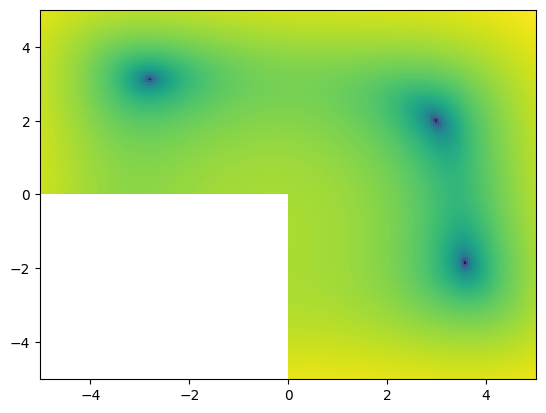

In [136]:
import matplotlib as mpl

def himmelblau(x1, x2):
    """
    Himmelblau's function (https://en.wikipedia.org/wiki/Himmelblau%27s_function)
    """
    f = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    return torch.Tensor(np.where((x1 > 0) | (x2 > 0), f, np.nan))


x = y = np.linspace(-5, 5, 256)

X1, X2 = np.meshgrid(x, y)

F = himmelblau(X1, X2)

plt.pcolormesh(X1, X2, F, norm=mpl.colors.LogNorm())

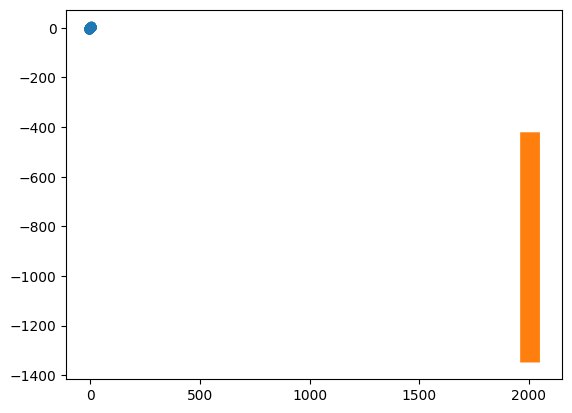

In [30]:
test_x = torch.linspace(1960, 2050, 1024).unsqueeze(-1)


p = model.posterior(test_x)


mean = p.mean.detach().squeeze()

stddev = p.variance.sqrt().detach().squeeze()

plt.scatter(x, y)
plt.fill_between(test_x.squeeze(), mean - stddev, mean + stddev)

In [470]:
X = 10 * torch.rand(size=(64, 2)).double() - 5
Y = himmelblau(*X.T).double()
Y = Y.unsqueeze(dim = -1)

InputDataError: Input data contains NaN values.

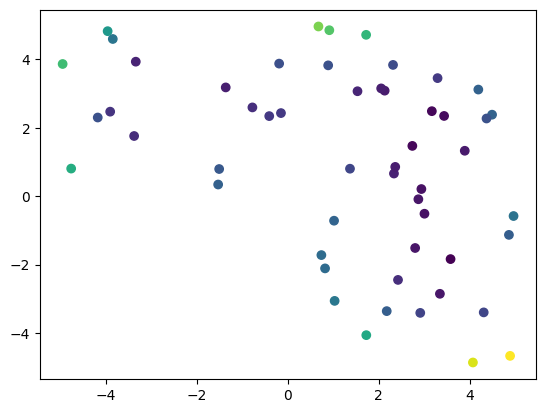

In [471]:
plt.scatter(*X.T, c=Y)

model = SingleTaskGP(X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))

In [10]:
import botorch

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

from botorch.optim import fit

meghas_long_term_kernel = custom_scaled_matern_kernel(lengthscale_constraint = gpytorch.constraints.GreaterThan(0.5), scale_constraint = gpytorch.constraints.GreaterThan(1))


model = SingleTaskGP(x, y, input_transform=Normalize(d=1), outcome_transform=Standardize(m=1), covar_module = (seasonal_kernel + meghas_long_term_kernel + irregularity_kernel))

botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))

NameError: name 'custom_scaled_matern_kernel' is not defined

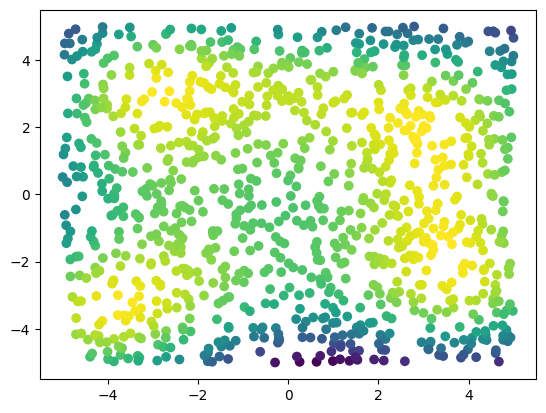

In [25]:
test_X = 10 * torch.rand(size=(1024, 1, 2)).double() - 5

p = model.posterior(test_X)

plt.scatter(*test_X.squeeze().T, c =p.mean.detach())

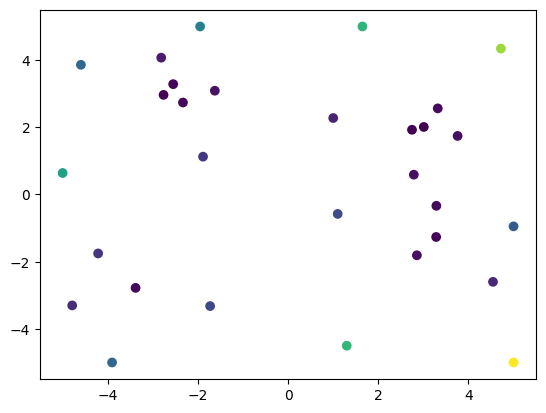

In [449]:
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
def himmelblau(x1, x2):
    """
    Himmelblau's function (https://en.wikipedia.org/wiki/Himmelblau%27s_function)
    """
    f = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    return f
    
num_itr = 20
X = (10 * torch.rand(size=(10, 2)).double() - 5) 
X = X[np.isnan(himmelblau(*X.T))==False]
Y = (-1)*himmelblau(*X.T).double()
#Y = (lambda x: torch.min(Y) if himmelblau(*x.T)==np.nan else (-1) * himmelblau(*x.T).double())(X)
Y = Y.unsqueeze(dim = -1)
#plt.scatter(*X.T, c=Y)
model = SingleTaskGP(X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
for i in range(num_itr):
    best_y = torch.max(Y)
    #optimize aquisition function
    bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
    acq_fun = ExpectedImprovement(model, best_y)
    candidate, acq_value = optimize_acqf(acq_fun, bounds = bounds, q=1, num_restarts=5, raw_samples = 20)
    #sample point add selected point to data
    X = torch.cat((X, candidate), 0)
    y_val = torch.min(Y).unsqueeze(-1) if np.isnan(himmelblau(*candidate.T)) else (-1) * himmelblau(*candidate.T).double()
    Y = torch.cat((Y.squeeze(), y_val), 0)
    Y = Y.unsqueeze(dim = -1)
    #refit the model
    model = SingleTaskGP(X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))

plt.scatter(*X.T, c=(-1)*Y)

In [8]:
def himmelblau(x1, x2):
    """
    Himmelblau's function (https://en.wikipedia.org/wiki/Himmelblau%27s_function)
    """
    f = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    return torch.Tensor(np.where((x1 > 0) | (x2 > 0), f, np.nan))

 25%|████████████████████▊                                                              | 5/20 [00:10<00:33,  2.20s/it]C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\optimize.py:588: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
 45%|█████████████████████████████████████▎                                             | 9/20 [00:21<00:27,  2.52s/it]C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\optimize.py:588: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of

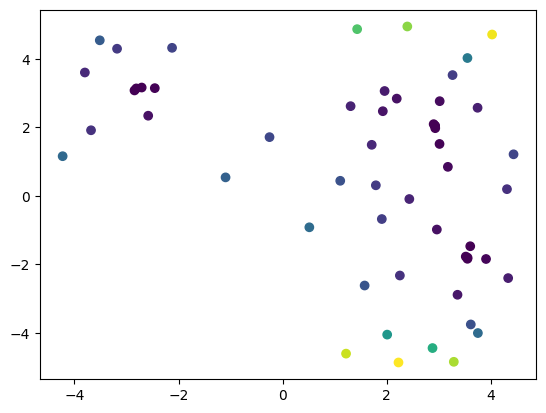

In [42]:
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.sampling import IIDNormalSampler
from tqdm import tqdm
num_itr = 20

class ConstrainedQExpectedImprovement(qExpectedImprovement):
    def __init__(self, model, constraint, **kwargs):
        super().__init__(model=model, **kwargs)
        self.constraint = constraint

    def forward(self, x):
        return super().forward(x) * self.constraint(x).squeeze()

X = (10 * torch.rand(size=(50, 2)).double() - 5)
#X= X.unsqueeze(1)
good_X = X[np.isnan(himmelblau(*X.squeeze().T))==False]
Y = himmelblau(*good_X.T).double()*(-1)
Y = Y.unsqueeze(dim = -1)
Quality = (-1) * np.isnan(himmelblau(*X.T)).double() + 1
Quality = Quality.unsqueeze(dim = -1)
model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))
for i in tqdm(range(num_itr)):
    #set best_y to the best value of the function we have achieved
    best_y = torch.max(Y)  #shouldn't best_y should be torch_min, since we are negating the function?
    #define bounds
    bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
    #set constraint function to be mean of posterior of Quality model, which should give us prob. that a point is good
    def constraint(x):
        return quality_model.posterior(x).mean.detach()
    #acq_fun = qExpectedImprovement(model, best_y)
    acq_fun = ConstrainedQExpectedImprovement(model = model, constraint = constraint, best_f = best_y) 
    #optimize aquisition function

    candidate, acq_value = optimize_acqf(acq_fun, bounds = bounds, q=1, num_restarts=5, raw_samples = 10)

    #add selected point to training data for quality model
    X = torch.cat((X, candidate), 0)
    Quality = torch.cat((Quality.squeeze(), (-1) * np.isnan(himmelblau(*candidate.T)).double() + 1), 0)
    Quality = Quality.unsqueeze(dim = -1)
    #if the point is sample-able, add point to data for main model
    if np.isnan(himmelblau(*candidate.T))==False:
        good_X = torch.cat((good_X, candidate), 0)
        y_val = himmelblau(*candidate.T).double()*(-1)
        Y = torch.cat((Y.squeeze(), y_val), 0)
        Y = Y.unsqueeze(dim = -1)
    #refit the model
    model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))

plt.scatter(*good_X.T, c=(-1)*Y)

In [2]:
test_X = 10 * torch.rand(size=(1024, 1, 2)).double() - 5
p = quality_model.posterior(test_X)
plt.scatter(*test_X.squeeze().T, c =(p.mean.detach()+1).round())
quality_model.posterior(torch.tensor([[-2, 2.1]])).mean
acq_fun(torch.tensor([[-2, 2.1]]))
plt.scatter(*test_X.squeeze().T, c =(acq_fun(test_X).detach()))

NameError: name 'torch' is not defined

In [43]:
acq_fun(torch.tensor([[1, 1], [1, 2]]))

tensor([0., 0.], dtype=torch.float64, grad_fn=<MulBackward0>)

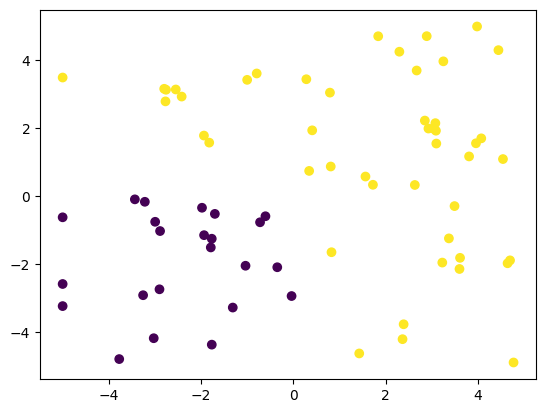

In [541]:
def gen_data(num_data):
    x = X[:, 0].unsqueeze(1)
    y = X[:, 1].unsqueeze(1)
    u = torch.rand(1)
    data_fn = lambda x, y: (-1) * np.isnan(himmelblau(x, y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn
train_x, Quality, genfn = gen_data(2)

plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = Quality)